## load libraries

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [9]:
# standard python packages
import os, sys, shutil
from os.path import dirname, basename
from glob import glob
import numpy as np
import pandas as pd
import warnings

In [3]:
# import toybrains
TOUYBRAINS_REPO = os.path.abspath("../../")
if TOUYBRAINS_REPO not in sys.path: sys.path.append(TOUYBRAINS_REPO)

from utils.DLutils import *
from utils.vizutils import *

In [4]:
DEEPREPVIZ_REPO = os.path.abspath("../../../Deep-confound-control-v2/")
if DEEPREPVIZ_REPO not in sys.path: sys.path.append(DEEPREPVIZ_REPO)

from DeepRepVizBackend import DeepRepVizBackend

OMP: Info #277: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


## Summarize results of the DL model training and DeepRepViz backend

In [25]:

# collect the DeepRepViz backend results in a dict
def collect_deeprepviz_results(logdirs, print_log=1):
    all_results = {}

    for logdir in logdirs:
        if print_log==1: print("loading logs from:", logdir)
        for deeprepvizlogdir in sorted(glob(f"{logdir}/*/deeprepvizlog")):
            iter_version = basename(dirname(deeprepvizlogdir))
            if print_log==1: print("loading run version:", iter_version)
            # ignore the missing conf_table warning from DeepRepVizBackend
            with warnings.catch_warnings():
                warnings.filterwarnings("ignore", message="Provided conf_table")
                drv_backend = DeepRepVizBackend()
            drv_backend.load_log(deeprepvizlogdir)

            log = drv_backend.deeprepvizlogs[deeprepvizlogdir]
            ckpt_idx = log['best_ckpt_idx']
            ckptname, log_ckpt = log['checkpoints'][ckpt_idx]
            logdirname = deeprepvizlogdir.split('/')[-3].replace('toybrains-','') 
            model_setting = logdirname.split('_')[-1]
            logdirname = logdirname.replace(model_setting, '').strip('_') 
            if print_log==2:
                print(f"{'='*100}\n {logdirname} :: \n\t setting: {model_setting} ")
                print(f"\t at ckpt: {ckptname} (idx={ckpt_idx}) \n\t ckpt contains: {list(log_ckpt.keys())}")
                print("\t Model accuracy : {}".format({k:f'{v*100:.2f}%' for k,v in log_ckpt['metrics'].items()}))
                
            result = {("Model",k): v for k,v in log_ckpt['metrics'].items()}
            if 'act_metrics' not in log_ckpt:
                print(f"[ERROR] Metrics not computed for {logdirname} at ckpt={ckptname} (idx={ckpt_idx}). Skipping...")
                continue
            else:
                for metric_name, metric_scores in log_ckpt['act_metrics'].items():
                    if print_log==2: print(f"\t {'-'*10} \t Metric = {metric_name} \t {'-'*30}")
                    for key in ['lbl_lesion', 'cov_site', 'brain-int_fill', 'shape-midr_curv', 'shape-midr_vol-rad']:
                        if print_log: print("\t {} \t=\t {:.4f}".format(key, metric_scores[key]))
                        result.update({(key, metric_name): metric_scores[key]})

            all_results.update({(model_setting, logdirname, iter_version): result})

    df_results = pd.DataFrame.from_dict(all_results, orient='index')
    df_results.index = df_results.index.set_names(['model_setting', 'model_name', 'trial'])
    df_results = df_results.sort_index(axis=1, level=[0,1]).sort_index()
    return df_results

In [56]:
def plot_deeprepviz_results(df_results, 
                            filter = '',
                            norm_metrics = 'dcor|mi|con|r2'):
    for feas, dfi in df_results.copy().reset_index(level=['model_name', 'trial']).groupby('model_name'):
        # drop the loss
        dfi = dfi.drop(columns=[('model_name', ''),('trial', ''), ('Model', 'loss')])
        # flatten the multi-index columns
        dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
        # sort the columns alphabetically
        dfi = dfi.reindex(sorted(dfi.columns), axis=1)
        # drop the costeta columns and additional user-defined filters
        dfi = dfi.filter(regex='^(?!.*costeta)')
        
        # normalize the metrics requested
        if norm_metrics != '':
            metric_cols = dfi.columns.str.contains(norm_metrics)
            dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
            lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)
    
        # apply 
        if filter != '':
            dfi = dfi.filter(regex=filter)

        # plot the results
        ax = sns.lineplot(dfi, err_style="bars", )
        sns.move_legend(ax, loc="upper center", bbox_to_anchor=(0.5, 1.5), ncols=4)
        plt.xticks(rotation=90)
        plt.title(f"DL model settings: {feas.split('_')}")
        plt.show()


In [62]:
# select the model runs for which we want to compare the results
cy = '*'
cX = 2
yX = 2
logdirs = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}/*/deeprepvizlog") if 'debug' not in log]
        )))

print("comparing results from n={} model logs:".format(len(logdirs)))
logdirs

comparing results from n=5 model logs:


['log/toybrains-cy0-cX2-yX2_SimpleCNN_c1-f3_cy0-cX2-yX2',
 'log/toybrains-cy1-cX2-yX2_SimpleCNN_c1-f3_cy1-cX2-yX2',
 'log/toybrains-cy2-cX2-yX2_SimpleCNN_c1-f3_cy2-cX2-yX2',
 'log/toybrains-cy3-cX2-yX2_SimpleCNN_c1-f3_cy3-cX2-yX2',
 'log/toybrains-cy4-cX2-yX2_SimpleCNN_c1-f3_cy4-cX2-yX2']

In [27]:
df_results = collect_deeprepviz_results(logdirs, print_log=False)
df_results.style.bar()

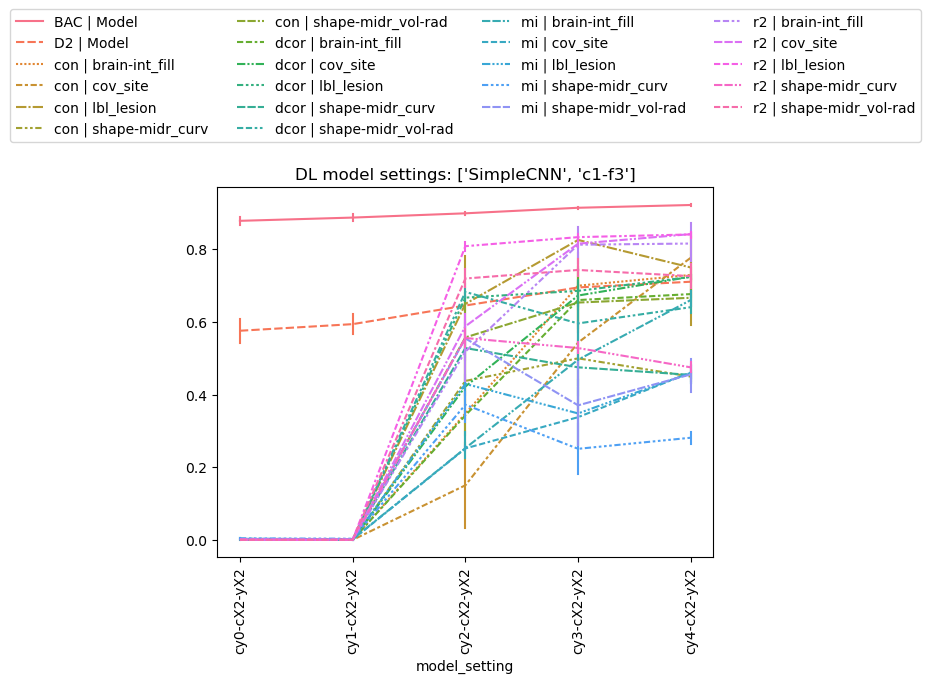

In [58]:
plot_deeprepviz_results(df_results, filter='', 
                        norm_metrics='')

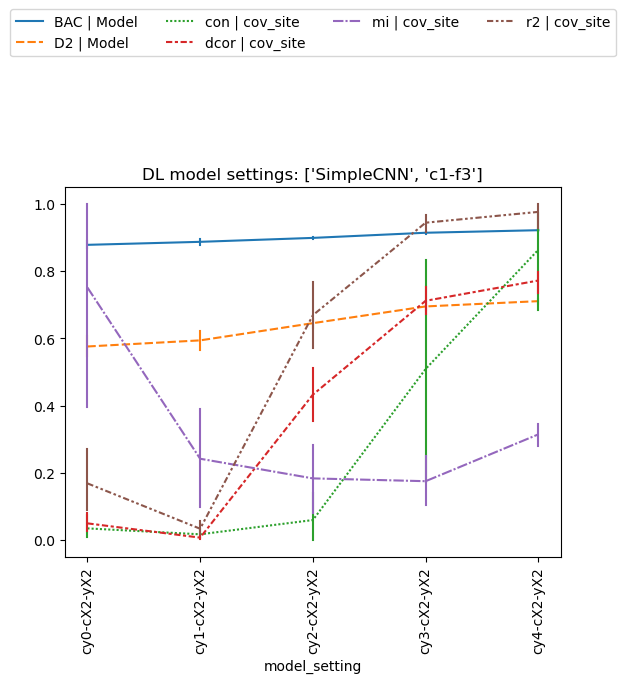

In [59]:
plot_deeprepviz_results(df_results, filter="(Model|cov_site)")

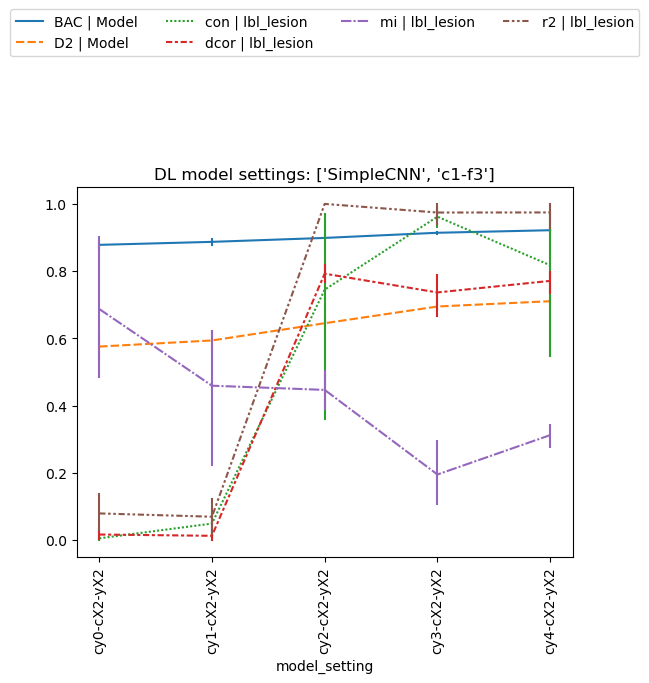

In [60]:
plot_deeprepviz_results(df_results, filter="(Model|lbl_lesion)")

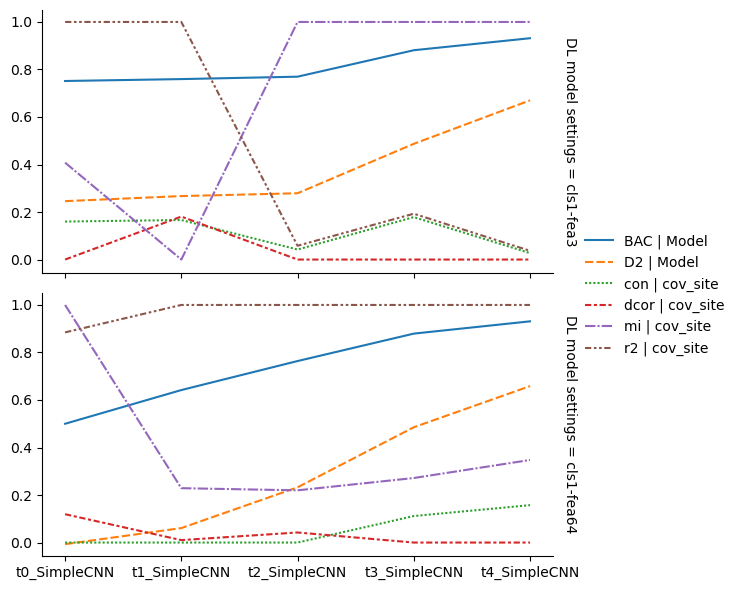

In [110]:
# custom_filter = "Model|cov_site" #|lbl_lesion|cov_site|brain-int_fill 
# dfi = df_results.copy()

# # drop the loss
# dfi = dfi.drop(columns=[('Model', 'loss')])
# # flatten the multi-index columns
# dfi.columns = [' | '.join(col[::-1]).strip() for col in dfi.columns.values]
# # sort the columns alphabetically
# dfi = dfi.reindex(sorted(dfi.columns), axis=1)
# # drop the costeta columns
# dfi = dfi.filter(regex='^(?!.*costeta)')
# # apply additional user-defined filters
# dfi = dfi.filter(regex=custom_filter)
# dfi = dfi.reset_index(level=0).rename(columns={'level_0': 'DL model settings'})
# # display(dfi)

# # normalize the metric scores
# metric_cols = dfi.columns.str.contains('dcor|mi|con|r2')
# dfi.loc[:, metric_cols] = dfi.loc[:, metric_cols].apply(
#     lambda x: (x - np.min(x)) / (np.max(x) - np.min(x)), axis=1)

# g = sns.FacetGrid(dfi, row='DL model settings',  margin_titles=True, 
#                   height=3, aspect=2)
# g.map_dataframe(sns.lineplot)
# g.add_legend()  
# # plt.tight_layout()
# plt.show()

### compare 2 model settings

In [64]:
cy = '*'
cX = 2
yX = 2
logdirs2 = sorted(
    list(set([
        (dirname(dirname(log))) for log in glob(f"log/toybrains*_cy{cy}-cX{cX}-yX{yX}*/*/deeprepvizlog") if 'debug' not in log]
        )))

print("comparing results from n={} model logs:".format(len(logdirs2)))
logdirs2

comparing results from n=10 model logs:


['log/toybrains-cy0-cX2-yX2_SimpleCNN_c1-f3_cy0-cX2-yX2',
 'log/toybrains-cy1-cX2-yX2_SimpleCNN_c1-f3_cy1-cX2-yX2',
 'log/toybrains-cy2-cX2-yX2_SimpleCNN_c1-f3_cy2-cX2-yX2',
 'log/toybrains-cy3-cX2-yX2_SimpleCNN_c1-f3_cy3-cX2-yX2',
 'log/toybrains-cy4-cX2-yX2_SimpleCNN_c1-f3_cy4-cX2-yX2',
 'log/toybrains_n10000_lblmidr-consite_cy0-cX2-yX2_SimpleCNN__c1-f256',
 'log/toybrains_n10000_lblmidr-consite_cy1-cX2-yX2_SimpleCNN__c1-f256',
 'log/toybrains_n10000_lblmidr-consite_cy2-cX2-yX2_SimpleCNN__c1-f256',
 'log/toybrains_n10000_lblmidr-consite_cy3-cX2-yX2_SimpleCNN__c1-f256',
 'log/toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN__c1-f256']

In [65]:
df_results2 = collect_deeprepviz_results(logdirs2, print_log=1)
df_results2.style.bar()

[ERROR] Metrics not computed for toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN at ckpt=epoch30-step001550 (idx=30). Skipping...
[ERROR] Metrics not computed for toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN at ckpt=epoch25-step001300 (idx=25). Skipping...
[ERROR] Metrics not computed for toybrains_n10000_lblmidr-consite_cy4-cX2-yX2_SimpleCNN at ckpt=epoch25-step001300 (idx=25). Skipping...


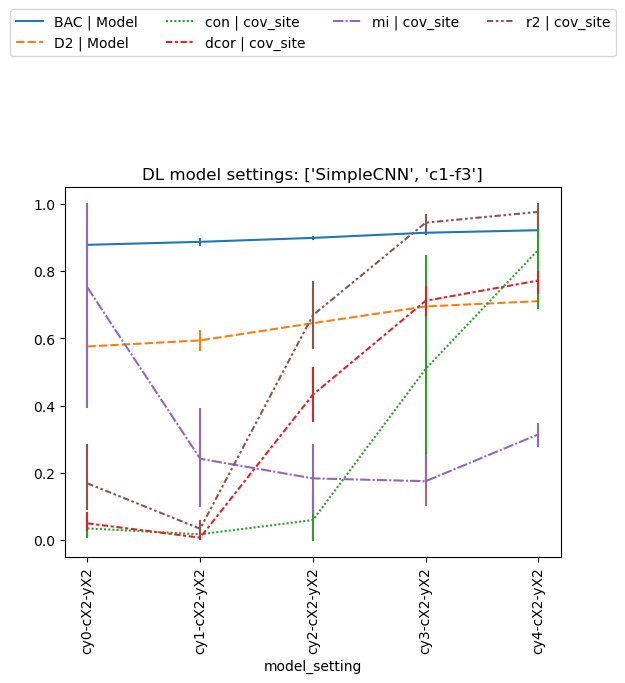

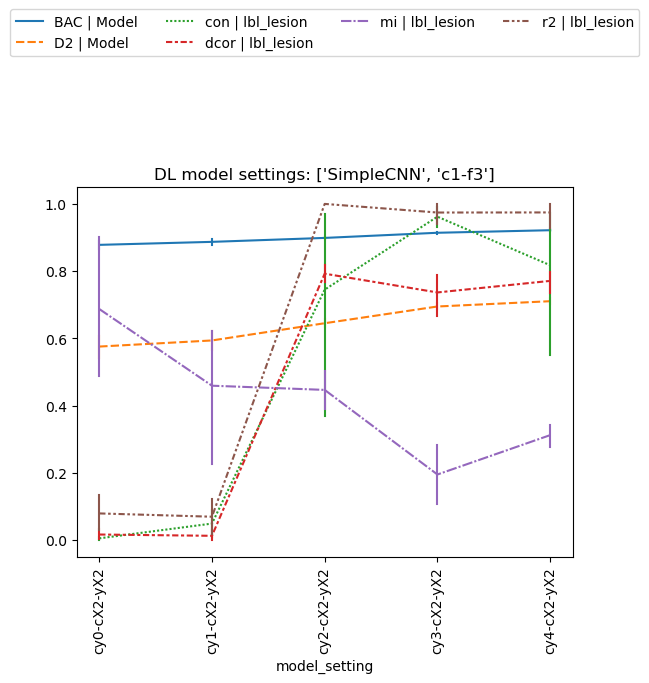

In [66]:
plot_deeprepviz_results(df_results, filter="(Model|cov_site)")
plot_deeprepviz_results(df_results, filter="(Model|lbl_lesion)")

#### test with a different 3D dimensionality reduction method?

In [19]:
# dim_reduct_method = TSNE(n_components=3, learning_rate='auto',
#                          init='random', perplexity=3) 

In [20]:
# %reload_ext tensorboard
# %tensorboard --logdir=./log/lightning_logs/
# !kill -9 1237900

#### Calculate other backend metrics ?